In [1]:
!pip install -q transformers
!pip install -q Pillow
!pip install -q matplotlib
!pip install -q opencv-python

gpu is available
Detected box: 0.33 at location [772.87, 194.88, 1205.59, 549.46]


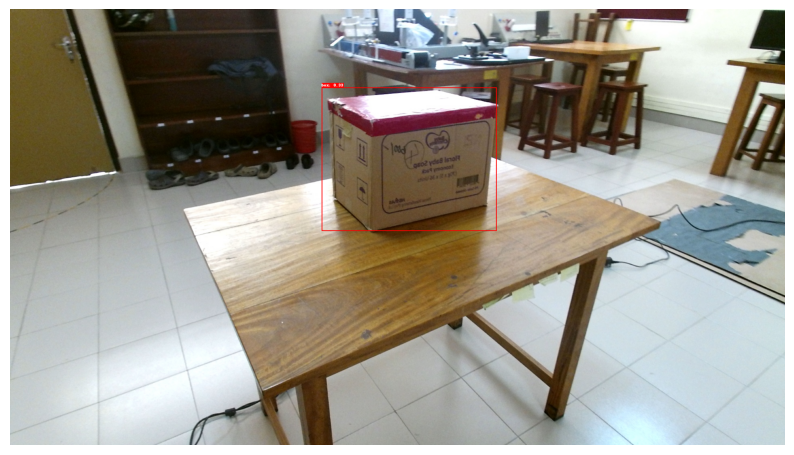

In [13]:
from PIL import Image, ImageDraw, ImageFont
import torch
from transformers import OwlViTProcessor, OwlViTForObjectDetection
import matplotlib.pyplot as plt

# Load the processor and model
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")

# Provide the path to your local image
image_path = "field.jpg"
image = Image.open(image_path)

# Define the text queries
texts = [["box"]]

import torch

# Use GPU if available
if torch.cuda.is_available():
    print("gpu is available")
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

# Set model in evaluation mode
model = model.to(device)
model.eval()

# Process the image and text
inputs = processor(text=texts, images=image, return_tensors="pt").to(device)
outputs = model(**inputs)

# Get target sizes and process object detection results
target_sizes = torch.Tensor([image.size[::-1]])
results = processor.post_process_object_detection(
    outputs=outputs, target_sizes=target_sizes, threshold=0.1
)

# Retrieve predictions for the first image
i = 0
text = texts[i]
boxes, scores, labels = results[i]["boxes"], results[i]["scores"], results[i]["labels"]

# Create a draw object
draw = ImageDraw.Draw(image)
# font = ImageFont.truetype("/path/to/arial.ttf", 50)


# Define a dictionary to map labels to colors https://matplotlib.org/stable/gallery/color/named_colors.html
label_colors = {
    0: "red",  # cat
    1: "green",  # dog
    2: "blue",  # remote control
    3: "yellow",
    4: "darkorange",
    5: "brown",
    6: "cyan",
    7: "indigo",
    8: "lime"
}

for box, score, label in zip(boxes, scores, labels):
    box = [round(i, 2) for i in box.tolist()]
    label_text = f"{text[label.item()]}: {round(score.item(), 2)}"
    print(f"Detected {label_text} at location {box}")

    # Convert the label tensor to an integer
    label_int = label.item()

    # Draw the bounding box with a specific color
    color = label_colors.get(label_int, "black")  # Use "black" as a default color if label_int is not in label_colors
    draw.rectangle(box, outline=color, width=2)

    # Calculate text size
    text_bbox = draw.textbbox((0, 0), label_text)
    text_width = text_bbox[2] - text_bbox[0]
    text_height = text_bbox[3] - text_bbox[1]

    # Draw a filled rectangle behind the text
    draw.rectangle(
        [box[0], box[1] - text_height, box[0] + text_width, box[1]],
        fill=color
    )
    draw.text((box[0], box[1] - text_height), label_text, fill="white")

# Display the image using matplotlib
plt.figure(figsize=(10, 10))
plt.imshow(image)
plt.axis("off")
plt.show()

In [14]:
# Get the image size
width, height = image.size

# Print the size
print(f"Image size: {width} x {height} pixels")

Image size: 1920 x 1080 pixels


In [11]:
import numpy as np
import matplotlib.pyplot as plt

def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))

def show_boxes_on_image(raw_image, boxes):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_on_image(raw_image, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    plt.axis('on')
    plt.show()

def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points_and_boxes_on_image(raw_image, boxes, input_points, input_labels=None):
    plt.figure(figsize=(10,10))
    plt.imshow(raw_image)
    input_points = np.array(input_points)
    if input_labels is None:
      labels = np.ones_like(input_points[:, 0])
    else:
      labels = np.array(input_labels)
    show_points(input_points, labels, plt.gca())
    for box in boxes:
      show_box(box, plt.gca())
    plt.axis('on')
    plt.show()


def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_masks_on_image(raw_image, masks, scores):
    if len(masks.shape) == 4:
      masks = masks.squeeze()
    if scores.shape[0] == 1:
      scores = scores.squeeze()

    nb_predictions = scores.shape[-1]
    fig, axes = plt.subplots(1, nb_predictions, figsize=(15, 15))

    for i, (mask, score) in enumerate(zip(masks, scores)):
      mask = mask.cpu().detach()
      axes[i].imshow(np.array(raw_image))
      show_mask(mask, axes[i])
      axes[i].title.set_text(f"Mask {i+1}, Score: {score.item():.3f}")
      axes[i].axis("off")
    plt.show()

In [15]:
import torch
from transformers import SamModel, SamProcessor

# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SamModel.from_pretrained("facebook/sam-vit-huge").to(device)
processor = SamProcessor.from_pretrained("facebook/sam-vit-huge")

config.json:   0%|          | 0.00/6.57k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/2.56G [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/466 [00:00<?, ?B/s]

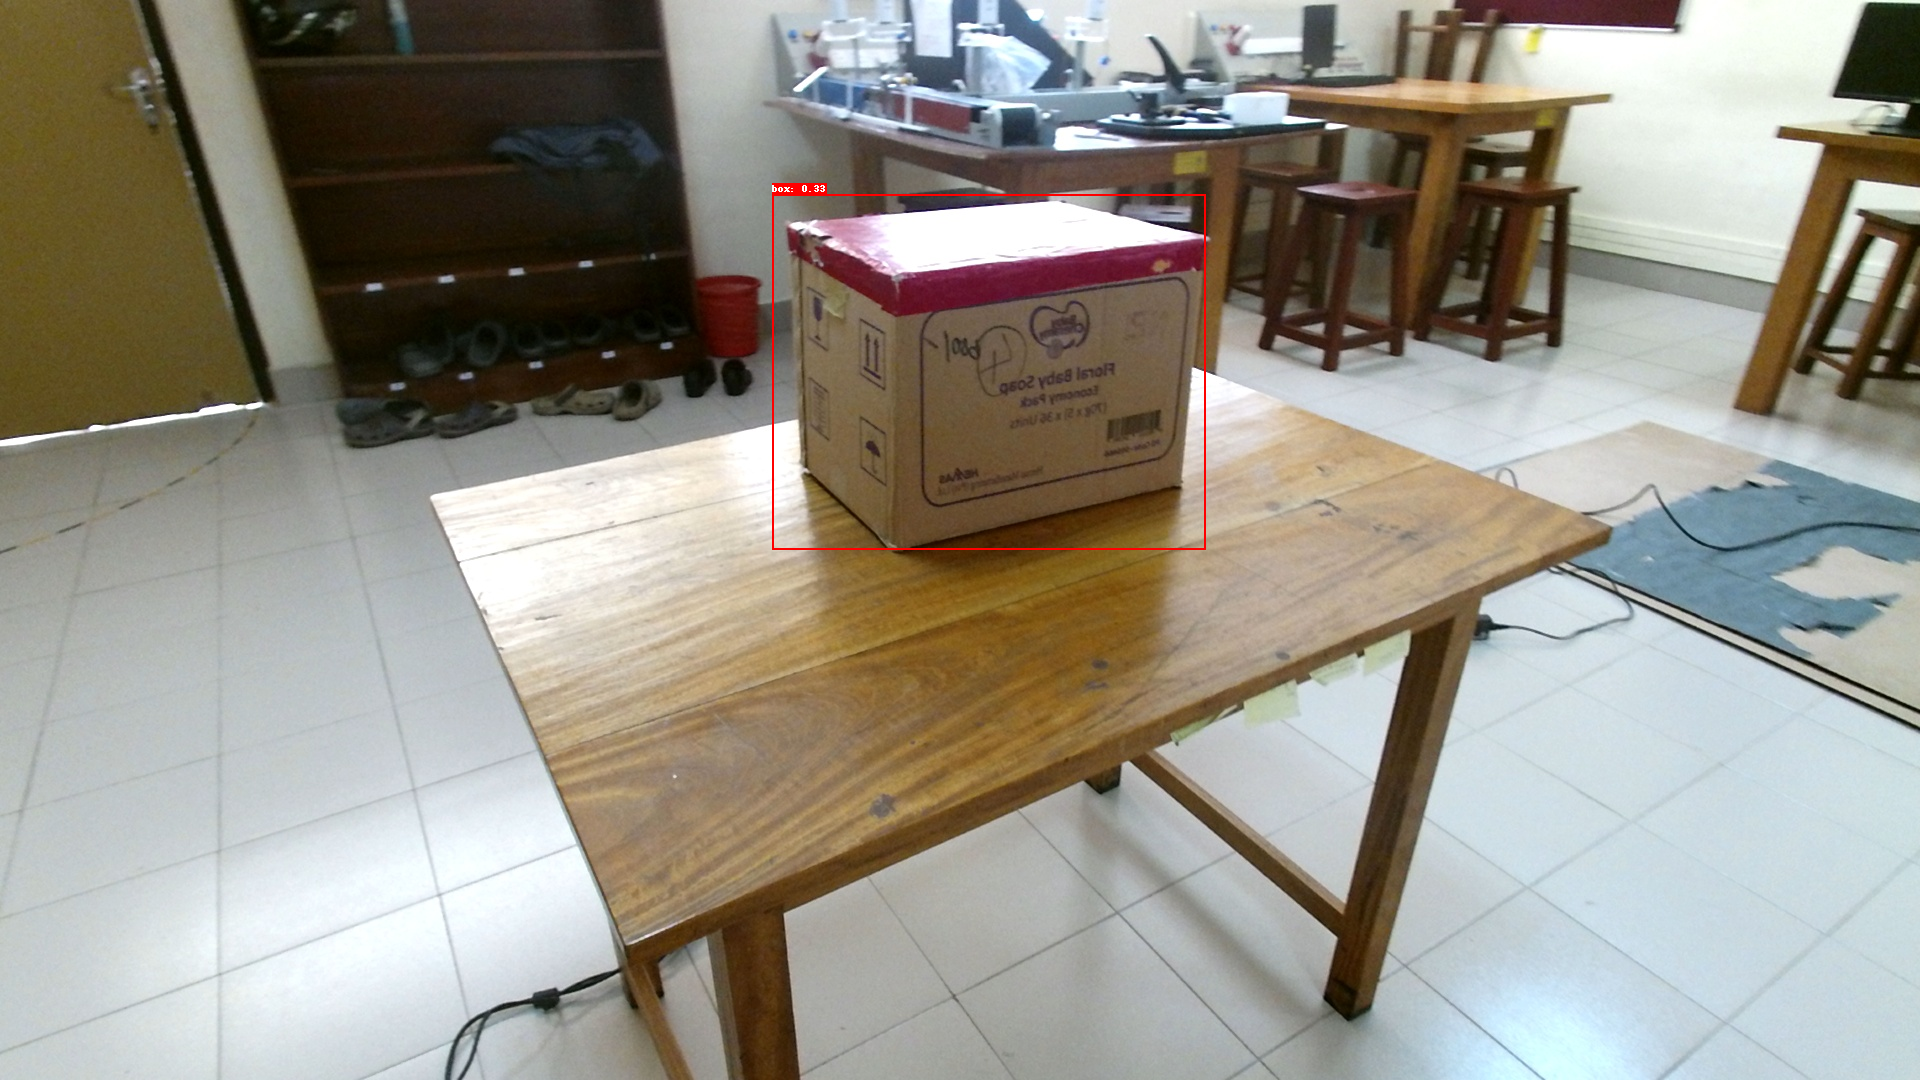

In [17]:
image

In [18]:
raw_image = Image.open('field.jpg')
inputs = processor(raw_image, return_tensors="pt").to(device)
image_embeddings = model.get_image_embeddings(inputs["pixel_values"])

In [23]:
inputs = processor(raw_image, input_points=input_points, return_tensors="pt").to(device)
# pop the pixel_values as they are not neded
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

In [26]:
input_boxes = [[box]]
inputs = processor(raw_image, input_boxes=[input_boxes], return_tensors="pt").to(device)
inputs["input_boxes"].shape

torch.Size([1, 1, 4])

In [27]:
inputs.pop("pixel_values", None)
inputs.update({"image_embeddings": image_embeddings})

with torch.no_grad():
    outputs = model(**inputs)

masks = processor.image_processor.post_process_masks(outputs.pred_masks.cpu(), inputs["original_sizes"].cpu(), inputs["reshaped_input_sizes"].cpu())
scores = outputs.iou_scores

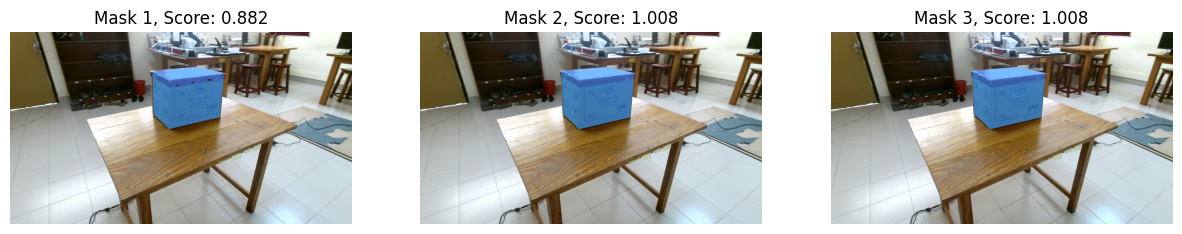

In [28]:
show_masks_on_image(raw_image, masks[0], scores)